# Imports

In [22]:
from google.oauth2 import service_account
from google.cloud import monitoring_v3
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
import matplotlib.dates as mdates

# Data Import

In [29]:
credentials = service_account.Credentials.from_service_account_file(
    '../infrastructure/credentials.json')

project_id = '932771810925' # Our project ID

client = monitoring_v3.MetricServiceClient(credentials=credentials)
project_name = f"projects/{project_id}"
now = time.time()
seconds = int(now)
nanos = int((now - seconds) * 10 ** 9)
interval = monitoring_v3.TimeInterval(
    {
        "end_time": {"seconds": seconds, "nanos": nanos},
        # 3600 = Get the last hour of metrics
        "start_time": {"seconds": (seconds - (3600 * 5)), "nanos": nanos},
    }
)

In [35]:
results_cpu = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type =  "compute.googleapis.com/instance/cpu/utilization"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_io_read = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/read_bytes_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_io_write = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/write_bytes_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_iops_read = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/read_ops_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_iops_write = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/write_ops_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)

def loadMonitoringData(experiment): 
    df = pd.DataFrame()
    set_timestamp_column = True
    first_len = 0
    for ts_cpu, ts_io_read, ts_io_write, ts_iops_read, ts_iops_write in zip(results_cpu, results_io_read, results_io_write, results_iops_read, results_iops_write):
        # print(ts)
        label = ts_cpu.metric.labels["instance_name"]
        if "orchestrator" in label:
            # Skip Orchesrtator
            continue
        if label.startswith(experiment):
            print(label + ": " + str(len(ts_cpu.points)))
            if set_timestamp_column:
                df['timestamp'] = pd.to_datetime([p.interval.start_time for p in ts_cpu.points])
                first_len=len(ts_cpu.points)
                set_timestamp_column = False
            # print(ts.points[0])
            # When deploying the vm they might take different amount of time leading to some values beeing available a minute early this leading to different length
            # We can trim off the last values as they are orderer from most recent to last
            df['cpu_util_' + label] = [p.value.double_value for p in ts_cpu.points[:first_len]]
            df['io_read_' + label] = [p.value.int64_value for p in ts_io_read.points[:first_len]]
            df['io_write_' + label] = [p.value.int64_value for p in ts_io_write.points[:first_len]]
            df['iops_read_' + label] = [p.value.int64_value for p in ts_iops_read.points[:first_len]]
            df['iops_write_' + label] = [p.value.int64_value for p in ts_iops_write.points[:first_len]]

    df.set_index('timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)
    columns = df.columns
    df.to_csv(f"monitoring_{experiment}.csv")
    return df

# loadMonitoringData("experiment-syncmesh-with-latency")
loadMonitoringData("experiment-baseline-with-latency")
df.head()



experiment-baseline-with-latency-syncmesh-instance-2: 77


ValueError: Length of values does not match length of index

# Test

## CPU

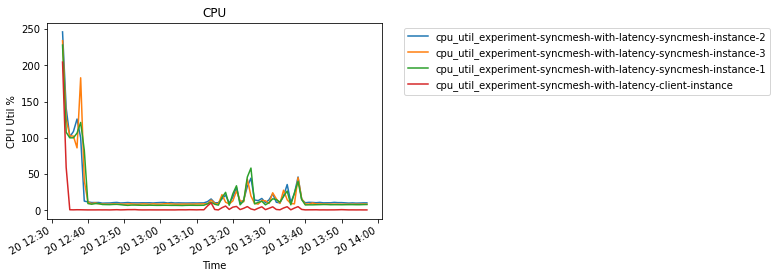

In [31]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("cpu_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IO

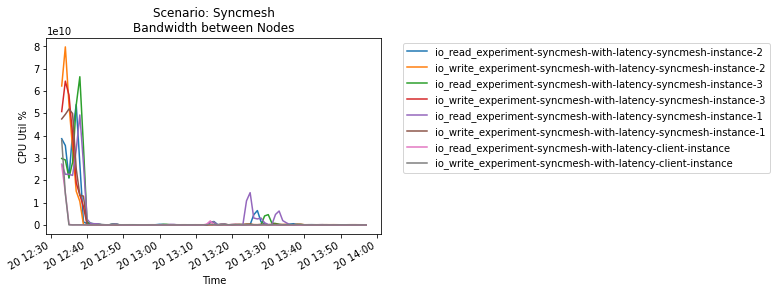

In [32]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("io_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IOPS

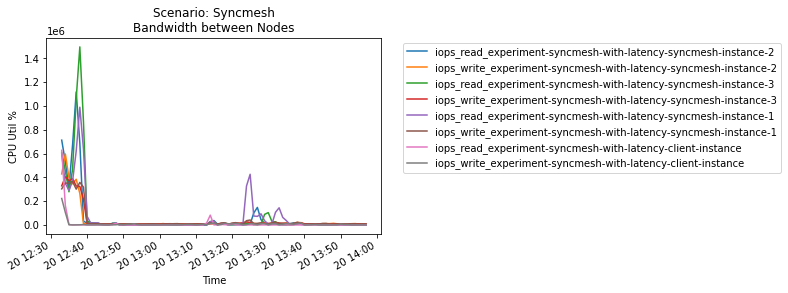

In [33]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("iops_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()